In [ ]:
pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 9.6 MB/s eta 0:00:00


In [ ]:
!pip install opendatasets

# Using GANs to Turn Photos into Van Gogh Style Pictures

In [ ]:
import opendatasets as od
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
import os
import zipfile
from io import BytesIO
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import array_to_img
from tensorflow.keras.losses import Reduction
import tensorflow_addons as tfa

import skimage
import skimage.io

AUTOTUNE = tf.data.experimental.AUTOTUNE

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## 1 Brief description of the problem and data

During week 5 of this course, DTSA 5511 Intro to Deep Learning,  we worked on the Kaggle competition "I'm Something of a Painter Myself," where we used GANs to turn photographs into Monet style paintings. That project inspired this final project. I wanted to work with a different artist, Vincent Van Gogh, and explore more hyperparameters for CycleGan. Like Monet, Van Gogh's work exhibits a unique style, present in hundreds of his paintings, like his famous 1889 "The Starry Night."

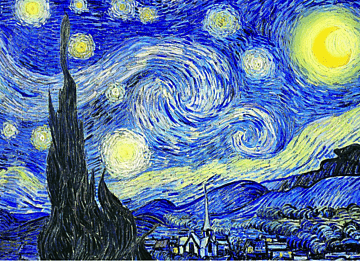

*The Starry Night, by Vincent Van Gogh, 1889*

This final project will use the photos from the Kaggle "I'm Something of a Painter Myself" dataset as they are a readily available set of 7028 photos that are already sized in 256 x 256 pixel TFrecord format.$^{1}$ If you are running this code locally, you will need to have your Kaggle API ready to enter your username and key in the next code block to upload to Colab.


In [ ]:
#You will need your Kaggle API info to upload these files locally in Colab
od.download("https://www.kaggle.com/competitions/gan-getting-started/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: heathermelrose
Your Kaggle Key: ··········


100%|██████████| 367M/367M [00:04<00:00, 88.2MB/s]



Extracting archive ./gan-getting-started/gan-getting-started.zip to ./gan-getting-started


Again if you are running this locally in Colab, before running the next block of code, you'll need to create a new folder in the gan-getting-started folder that you just created, name it **vangogh_tfrec**, then upload the Van_images.tfrecord file provided for you in my Github repository. If you accessed this notebook outside of my repository, please jump to Section 7 below for the link. In this file there are 342 Van Gogh paintings also sized 256 x 256 in TFrecord format.$^{2}$

In [ ]:
Monet_names = tf.io.gfile.glob(str('gan-getting-started/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(Monet_names))

photo_names = tf.io.gfile.glob(str('gan-getting-started/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(photo_names))

Vangogh_names = tf.io.gfile.glob(str('gan-getting-started/vangogh_tfrec/*.tfrecord'))
print('Vangogh TFRecord Files:', len(Vangogh_names))

Monet TFRecord Files: 5
Photo TFRecord Files: 20
Vangogh TFRecord Files: 1


Note that instead of being broken up into 5 files of 60 TFrecords each like the Monet set, the Van Gogh files are all in the same file within the vangogh_tfrec folder.

## 2 Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

The above artwork example is one of Van Gogh's most famous paintings and it is an excellent representation of Van Gogh's art, our goal output. Kaggle provided two versions of the photographs, one jpg and the other tfrec, each with 7028 photos. We are choosing in this paper to work with the tfrec files to make use of the Keras methods.$^{3}$ TFRecords are files that TensorFlow uses to store binary data in sequences of byte-strings. The code below was learned from https://keras.io and the Kaggle Tutorial "TFRecords Basics." Let's decode the tfrecords, reshape and load our datasets,$^{4}$

In [ ]:
image_size = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*image_size, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [ ]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [ ]:
photo_set = load_dataset(photo_names, labeled=True).batch(1)
Vangogh_set = load_dataset(Vangogh_names).batch(1)

example_photo = next(iter(photo_set))
example_vangogh = next(iter(Vangogh_set))

Here is an example of the data in each type of file, photo and Van Gogh.

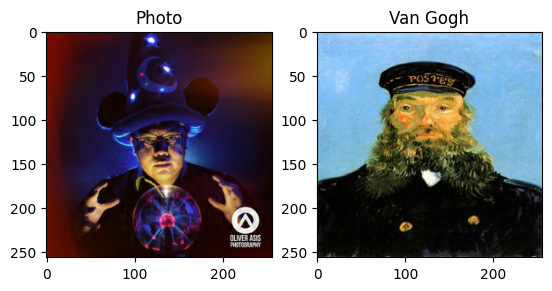

In [ ]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Van Gogh')
plt.imshow(example_vangogh[0] * 0.5 + 0.5)

## 3 Model Architecture

GANs, or Generative Adversarial Networks, begin with noise and learn to create a very realistic output. In recent years this has been done with audio, visual, and text to picture. How does a computer learn to make things out of thin air? As seen below, the generator, G, will convert a real image into a Van Gogh style picture. In the beginning, generator does not perform very well because it has not been taught what to do. (It turns out that good teachers are very important in this world, not just for humans, but I digress.) This is where the discriminator comes in. The discriminator, D, alternates looking at real Van Goghs and generator produced, fake Van Goghs. It then gives feedback to the generator via back propagation. It is through this feedback that the generator learns. In CycleGan, another generator, F, could be developed to convert the Van Gogh style painting into a real photograph, but that is outside the scope of this paper.


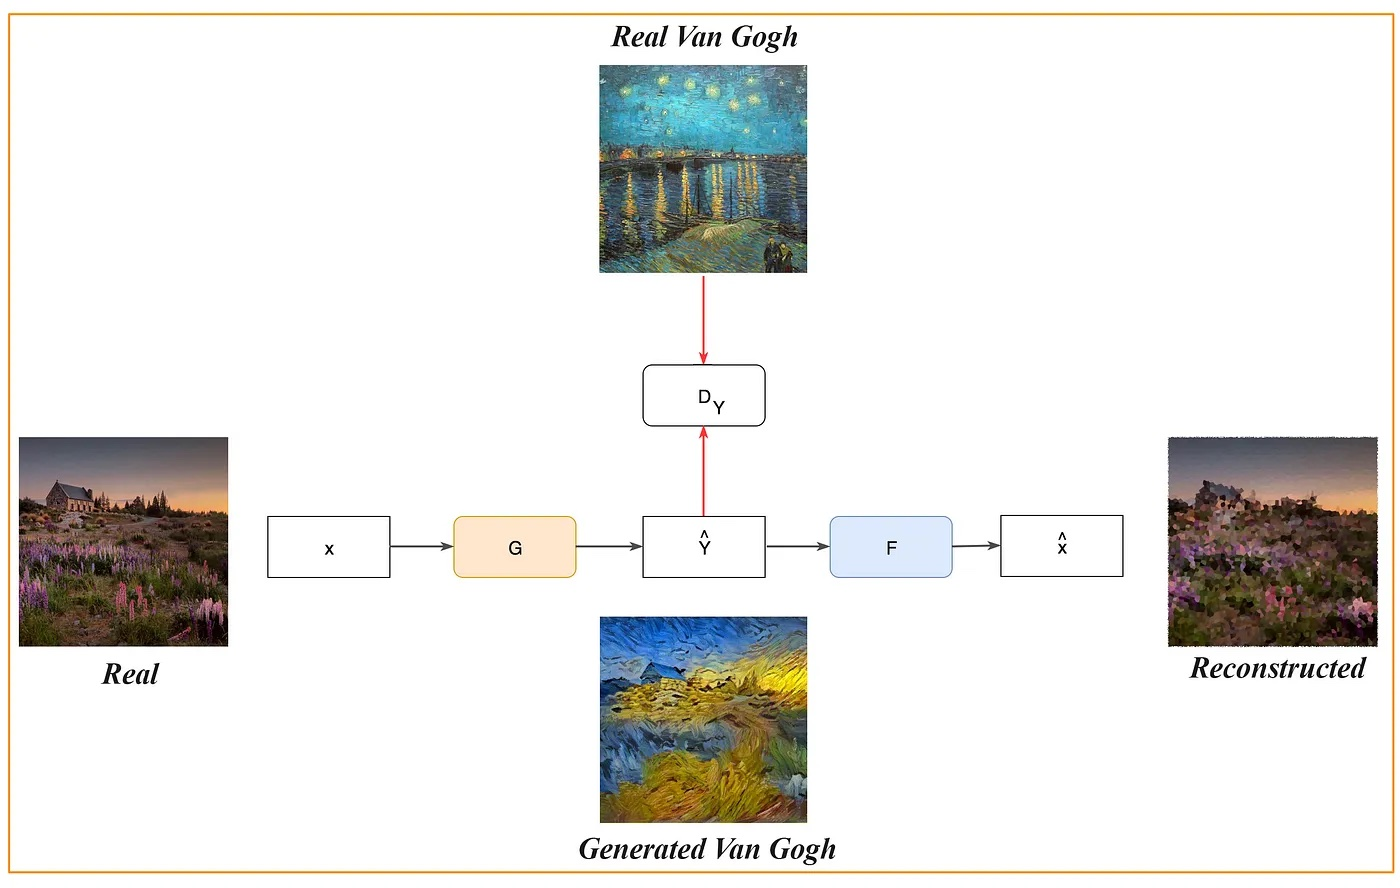

*Image credit - Jonathan Hui* $^{5}$


Inside the generator, we will take the full input image and downsample it, or reduce it in resolution while keeping the same 2D shape. Then we will upsample, or increase the spatial resolution again maintaining the 2D shape.$^{6}$ The downsample and upsample helper functions will allow us to do this multiple times.  The following code was learned from an excellent tutorial on Kaggle, "Monet CycleGAN Tutorial."$^{7}$

In [ ]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

In [ ]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

In [ ]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)

    return tf.keras.Model(inputs=inp, outputs=last)

Now we want to use our generator and discriminator functions.

*   Vangogh_gen will transform a photo into a Monet-style painting
*   photo_gen will transform a Monet painting into a realistic looking photo

*   Vangogh_disc differentiates between the real and generated Monets
*   photo_disc differentiates between the real and generated photos





In [ ]:
Vangogh_gen = Generator()
photo_gen = Generator()

Vangogh_disc = Discriminator()
photo_disc = Discriminator()

When we try running a photo through the generator without using the discriminator, the generator fails to produce a painting.

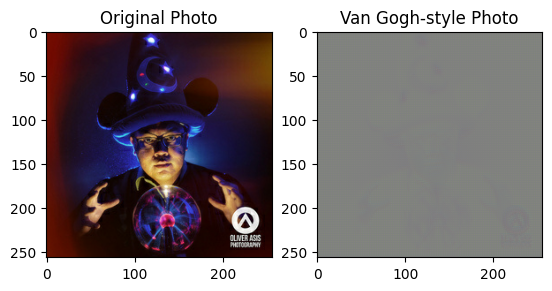

In [ ]:
to_vangogh = Vangogh_gen(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Van Gogh-style Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

The same is true if we start with a Van Gogh,

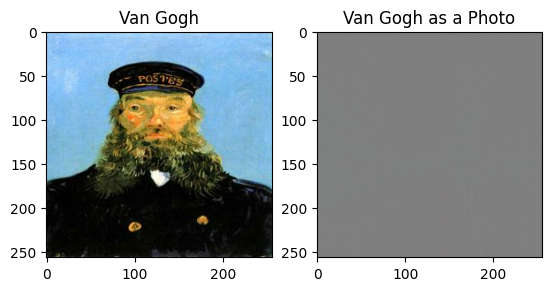

In [ ]:
to_photo = photo_gen(example_monet)

plt.subplot(1, 2, 1)
plt.title("Van Gogh")
plt.imshow(example_vangogh[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Van Gogh as a Photo")
plt.imshow(to_photo[0] * 0.5 + 0.5)
plt.show()

This happens because the generator, without learning through back propagation from the discriminator, can only output the noise that it recieves.$^{8}$

Over the past few years, many different types of GANs have been created. CycleGAN is especially adept at image-to-image translation.$^{9}$ Examples that have been created include translating summer landscapes into winter (and vice versa), translating horses into zebras (and vice versa), and translating paintings into photographs, or like vice versa like this project.$^{10}$

In [ ]:
class CycleGan(keras.Model):
    def __init__(
        self,
        Vangogh_gen,
        photo_gen,
        Vangogh_disc,
        photo_disc,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = Vangogh_gen
        self.p_gen = photo_gen
        self.m_disc = Vangogh_disc
        self.p_disc = photo_disc
        self.lambda_cycle = lambda_cycle

    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_vangogh, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # photo to Van Gogh back to photo
            fake_vangogh = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_vangogh, training=True)

            # Van Gogh to photo back to Van Gogh
            fake_photo = self.p_gen(real_vangogh, training=True)
            cycled_vangogh = self.m_gen(fake_photo, training=True)

            # generating itself
            same_vangogh = self.m_gen(real_vangogh, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_vangogh = self.m_disc(real_vangogh, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_vangogh = self.m_disc(fake_vangogh, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            vangogh_gen_loss = self.gen_loss_fn(disc_fake_vangogh)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_vangogh, cycled_vangogh, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_vangogh_gen_loss = vangogh_gen_loss + total_cycle_loss + self.identity_loss_fn(real_vangogh, same_vangogh, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            vangogh_disc_loss = self.disc_loss_fn(disc_real_vangogh, disc_fake_vangogh)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        vangogh_generator_gradients = tape.gradient(total_vangogh_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        vangogh_discriminator_gradients = tape.gradient(vangogh_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(vangogh_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(vangogh_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))

        return {
            "vangogh_gen_loss": total_vangogh_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "vangogh_disc_loss": vangogh_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

We are going to use loss functions as our measuring metric. We will define those helper functions here,

In [ ]:
def discriminator_loss(real, generated):
    full_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
    gen_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
    disc_loss = full_loss + gen_loss
    return disc_loss * 0.5

def generator_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

def identity_loss(real_image, same_image, LAMBDA):
    loss2 = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss2

During the reasearch phase of this project and that of week 5, most of the CycleGan examples that I found used Adam as an optimizer. In week 5, I chose to use RMSProp because conceptually I found it to be more straight forward. RMSprop uses the moving average in calculating gradient descent. In an attempt to improve my model from week 5$^{11}$, I am going to start with Adam as an optimizer. In addition to adapting the learning rate parameters based on the mean, as is done in RMSProp, Adam also uses the average of uncentered variance to adjust the weights.$^{12}$  

In [ ]:
Vangogh_gen_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_gen_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

Vangogh_disc_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_disc_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

Now we are ready to put all of the pieces together for our CycleGAN model,

In [ ]:
cycle_gan_model = CycleGan(Vangogh_gen, photo_gen, Vangogh_disc, photo_disc)

cycle_gan_model.compile(
    m_gen_optimizer = Vangogh_gen_opt,
    p_gen_optimizer = photo_gen_opt,
    m_disc_optimizer = Vangogh_disc_opt,
    p_disc_optimizer = photo_disc_opt,
    gen_loss_fn = generator_loss,
    disc_loss_fn = discriminator_loss,
    cycle_loss_fn = calc_cycle_loss,
    identity_loss_fn = identity_loss
)

## 4 Results and Analysis

Much as humans learn over time, so do machines. Let's start with 5 epochs and see how well the model with an Adam optimizer performs.

In [ ]:
hist1 = cycle_gan_model.fit(tf.data.Dataset.zip((Vangogh_set, photo_set)),epochs=5)

Epoch 1/5
342/342 [==============================] - 213s 460ms/step - vangogh_gen_loss: 5.4694 - photo_gen_loss: 5.3653 - vangogh_disc_loss: 0.6066 - photo_disc_loss: 0.6357
Epoch 2/5
342/342 [==============================] - 157s 460ms/step - vangogh_gen_loss: 3.8872 - photo_gen_loss: 3.8686 - vangogh_disc_loss: 0.6608 - photo_disc_loss: 0.6344
Epoch 3/5
342/342 [==============================] - 157s 459ms/step - vangogh_gen_loss: 3.7696 - photo_gen_loss: 3.7294 - vangogh_disc_loss: 0.6261 - photo_disc_loss: 0.6370
Epoch 4/5
342/342 [==============================] - 157s 459ms/step - vangogh_gen_loss: 3.5526 - photo_gen_loss: 3.5142 - vangogh_disc_loss: 0.6290 - photo_disc_loss: 0.6484
Epoch 5/5
342/342 [==============================] - 157s 459ms/step - vangogh_gen_loss: 3.3719 - photo_gen_loss: 3.3447 - vangogh_disc_loss: 0.6193 - photo_disc_loss: 0.6435


The result of running 5 epochs is,

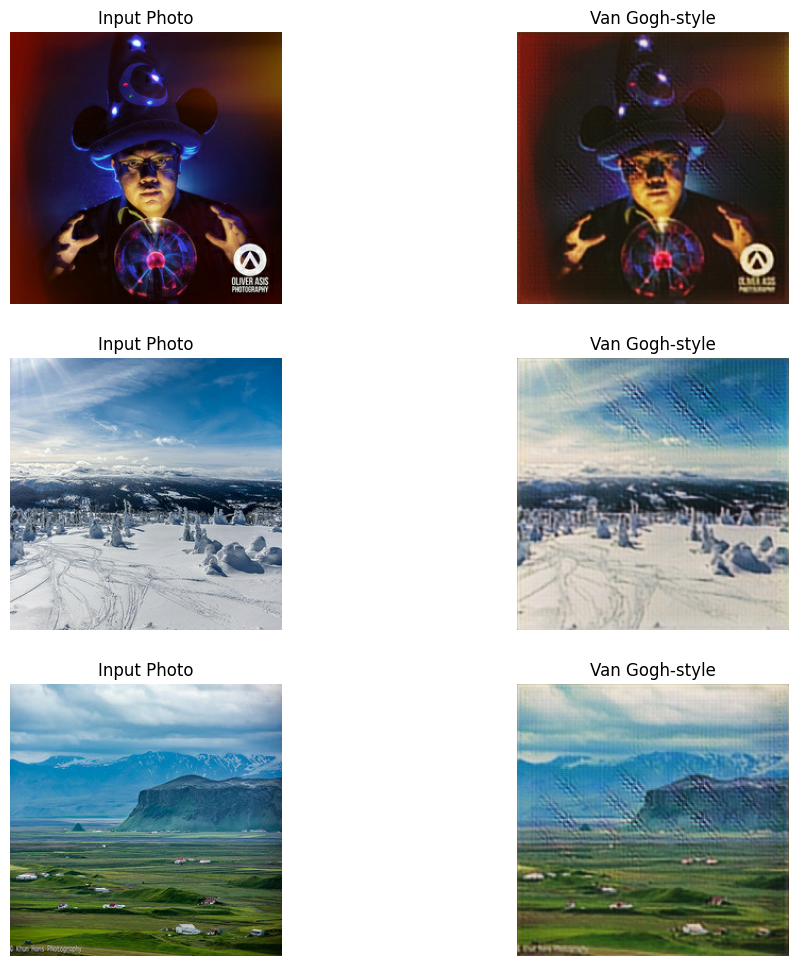

In [ ]:
_, ax = plt.subplots(3, 2, figsize=(12, 12))
for i, img in enumerate(photo_set.take(3)):
    prediction = Vangogh_gen(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Van Gogh-style")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

Visually, we can see that 5 epochs is enough to start changing the photographes. Let's run the model for a little longer, 15 epochs,

In [ ]:
hist2 = cycle_gan_model.fit(tf.data.Dataset.zip((Vangogh_set, photo_set)),epochs=15)

Epoch 1/15
342/342 [==============================] - 157s 459ms/step - vangogh_gen_loss: 3.2777 - photo_gen_loss: 3.2548 - vangogh_disc_loss: 0.6188 - photo_disc_loss: 0.6353
Epoch 2/15
342/342 [==============================] - 157s 459ms/step - vangogh_gen_loss: 3.2193 - photo_gen_loss: 3.1964 - vangogh_disc_loss: 0.6157 - photo_disc_loss: 0.6337
Epoch 3/15
342/342 [==============================] - 157s 459ms/step - vangogh_gen_loss: 3.1841 - photo_gen_loss: 3.1554 - vangogh_disc_loss: 0.6145 - photo_disc_loss: 0.6331
Epoch 4/15
342/342 [==============================] - 157s 458ms/step - vangogh_gen_loss: 3.1467 - photo_gen_loss: 3.1218 - vangogh_disc_loss: 0.6179 - photo_disc_loss: 0.6322
Epoch 5/15
342/342 [==============================] - 157s 459ms/step - vangogh_gen_loss: 3.1067 - photo_gen_loss: 3.0876 - vangogh_disc_loss: 0.6176 - photo_disc_loss: 0.6291
Epoch 6/15
342/342 [==============================] - 156s 457ms/step - vangogh_gen_loss: 3.0770 - photo_gen_loss: 3.061

The results for 15 epochs looks like,

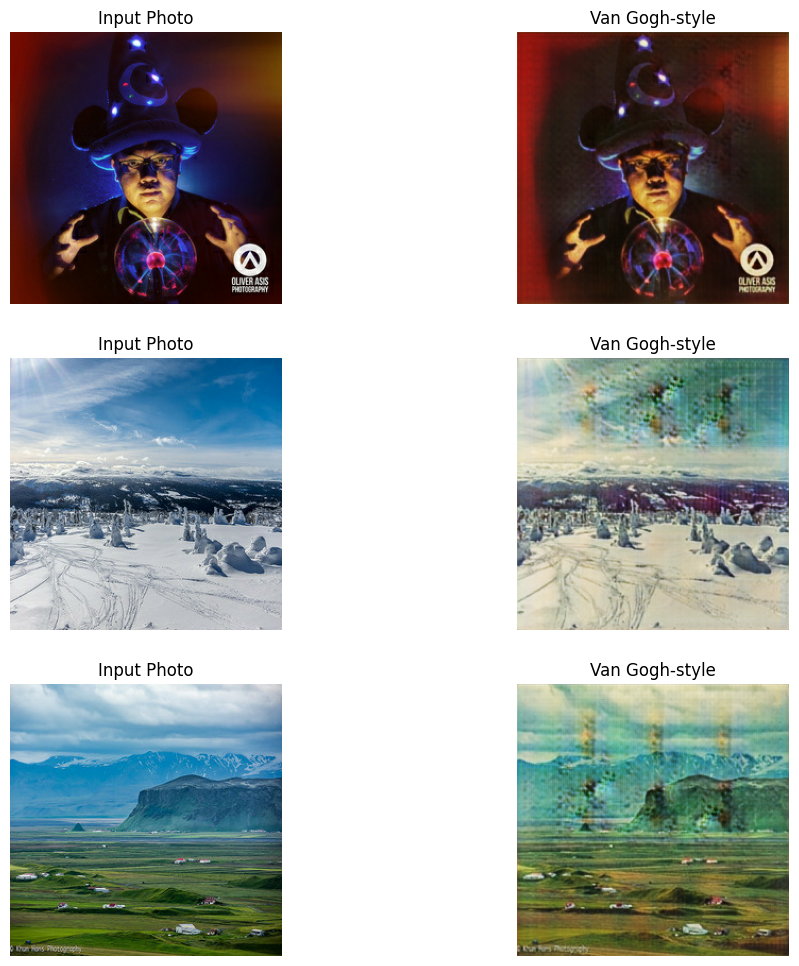

In [ ]:
_, ax = plt.subplots(3, 2, figsize=(12, 12))
for i, img in enumerate(photo_set.take(3)):
    prediction = Vangogh_gen(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Van Gogh-style")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

At a glance, the loss seems to be worse than what was calculated during the Week 5 project. Let's switch back to using RMSProp, as I did in Week 5, to see if we can reduce loss and build a better model.

In [ ]:
Vangogh_gen_opt_rms = tf.keras.optimizers.RMSprop()
photo_gen_opt_rms = tf.keras.optimizers.RMSprop()

Vangogh_disc_opt_rms = tf.keras.optimizers.RMSprop()
photo_disc_opt_rms = tf.keras.optimizers.RMSprop()

In [ ]:
cycle_gan_model_rms = CycleGan(Vangogh_gen, photo_gen, Vangogh_disc, photo_disc)

cycle_gan_model_rms.compile(
    m_gen_optimizer = Vangogh_gen_opt_rms,
    p_gen_optimizer = photo_gen_opt_rms,
    m_disc_optimizer = Vangogh_disc_opt_rms,
    p_disc_optimizer = photo_disc_opt_rms,
    gen_loss_fn = generator_loss,
    disc_loss_fn = discriminator_loss,
    cycle_loss_fn = calc_cycle_loss,
    identity_loss_fn = identity_loss
)

In [ ]:
hist3 = cycle_gan_model_rms.fit(tf.data.Dataset.zip((Vangogh_set, photo_set)),epochs=5)

Epoch 1/5
342/342 [==============================] - 206s 458ms/step - vangogh_gen_loss: 3.1829 - photo_gen_loss: 3.1896 - vangogh_disc_loss: 0.6784 - photo_disc_loss: 0.6753
Epoch 2/5
342/342 [==============================] - 155s 452ms/step - vangogh_gen_loss: 2.9657 - photo_gen_loss: 2.9616 - vangogh_disc_loss: 0.6411 - photo_disc_loss: 0.6551
Epoch 3/5
342/342 [==============================] - 155s 453ms/step - vangogh_gen_loss: 2.8811 - photo_gen_loss: 2.8807 - vangogh_disc_loss: 0.6390 - photo_disc_loss: 0.6467
Epoch 4/5
342/342 [==============================] - 155s 453ms/step - vangogh_gen_loss: 2.8403 - photo_gen_loss: 2.8373 - vangogh_disc_loss: 0.6355 - photo_disc_loss: 0.6494
Epoch 5/5
342/342 [==============================] - 154s 452ms/step - vangogh_gen_loss: 2.7760 - photo_gen_loss: 2.8039 - vangogh_disc_loss: 0.6447 - photo_disc_loss: 0.6499


The result of running 5 epochs with RMSProp is,

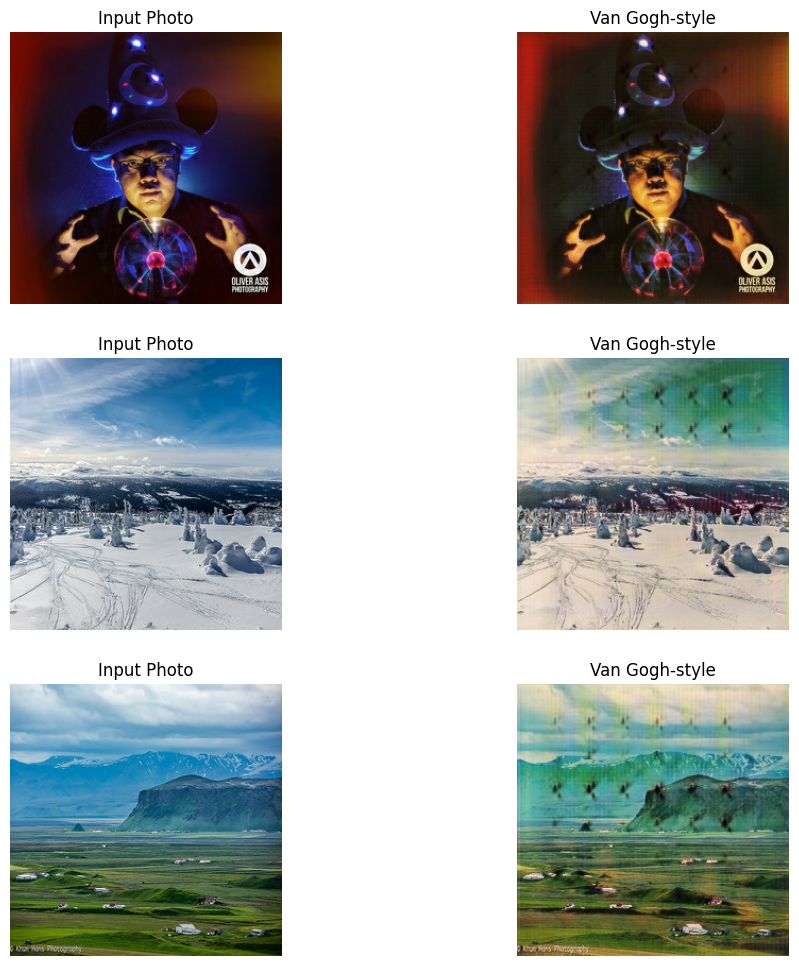

In [ ]:
_, ax = plt.subplots(3, 2, figsize=(12, 12))
for i, img in enumerate(photo_set.take(3)):
    prediction = Vangogh_gen(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Van Gogh-style")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

If we visually compare pictures produced by the two optimizers when run for 5 epochs, RMSProp is producing results faster. Let's see how it performs over 15 epochs,

In [ ]:
hist4 = cycle_gan_model_rms.fit(tf.data.Dataset.zip((Vangogh_set, photo_set)),epochs=15)

Epoch 1/15
342/342 [==============================] - 155s 452ms/step - vangogh_gen_loss: 2.7548 - photo_gen_loss: 2.8167 - vangogh_disc_loss: 0.6524 - photo_disc_loss: 0.6429
Epoch 2/15
342/342 [==============================] - 155s 452ms/step - vangogh_gen_loss: 2.7093 - photo_gen_loss: 2.7697 - vangogh_disc_loss: 0.6546 - photo_disc_loss: 0.6468
Epoch 3/15
342/342 [==============================] - 155s 452ms/step - vangogh_gen_loss: 2.6678 - photo_gen_loss: 2.7452 - vangogh_disc_loss: 0.6571 - photo_disc_loss: 0.6482
Epoch 4/15
342/342 [==============================] - 154s 451ms/step - vangogh_gen_loss: 2.6931 - photo_gen_loss: 2.7593 - vangogh_disc_loss: 0.6525 - photo_disc_loss: 0.6425
Epoch 5/15
342/342 [==============================] - 154s 451ms/step - vangogh_gen_loss: 2.6868 - photo_gen_loss: 2.7630 - vangogh_disc_loss: 0.6535 - photo_disc_loss: 0.6372
Epoch 6/15
342/342 [==============================] - 155s 452ms/step - vangogh_gen_loss: 2.6867 - photo_gen_loss: 2.738

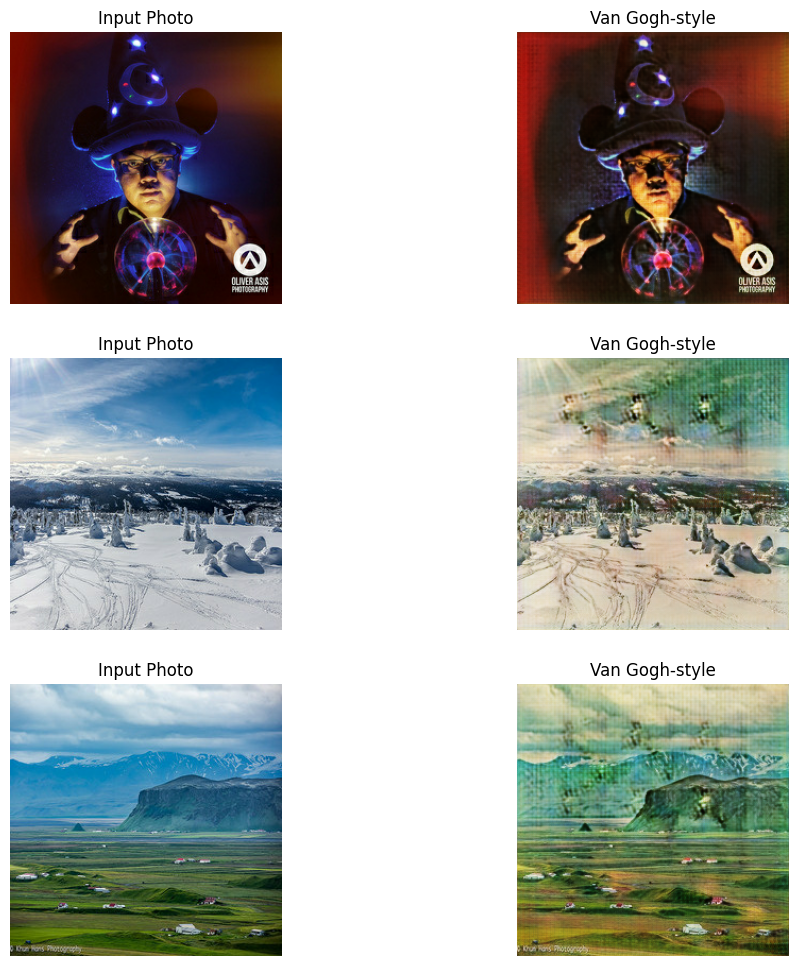

In [ ]:
_, ax = plt.subplots(3, 2, figsize=(12, 12))
for i, img in enumerate(photo_set.take(3)):
    prediction = Vangogh_gen(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Van Gogh-style")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

Visually, there is a noticable difference in the pairwise comparisons. Let's look at a table of the final loss values,

In [ ]:
print(tabulate([['Adam opt, 5 Epochs', 3.3719, 3.3447, 0.6193, 0.6435],
                ['Adam opt, 15 Epochs', 2.7413, 2.8216, 0.6470, 0.6379],
                ['RMSprop opt, 5 Epochs', 2.7760, 2.8039, 0.6447, 0.6499],
                ['RMSprop opt, 15 Epochs', 2.6005, 2.6803, 0.6570, 0.6437]],
               headers=['Model', 'Van Gogh Generator Loss', 'Photo Generator Loss', 'Van Gogh Discriminator Loss', 'Photo Discriminator Loss']))

Model                     Van Gogh Generator Loss    Photo Generator Loss    Van Gogh Discriminator Loss    Photo Discriminator Loss
----------------------  -------------------------  ----------------------  -----------------------------  --------------------------
Adam opt, 5 Epochs                         3.3719                  3.3447                         0.6193                      0.6435
Adam opt, 15 Epochs                        2.7413                  2.8216                         0.647                       0.6379
RMSprop opt, 5 Epochs                      2.776                   2.8039                         0.6447                      0.6499
RMSprop opt, 15 Epochs                     2.6005                  2.6803                         0.657                       0.6437


The RMSProp generator loss values are comparable to those found when using the Monet dataset in Week 5. Comparing the two optimizers head to head over the 15 epochs we get,

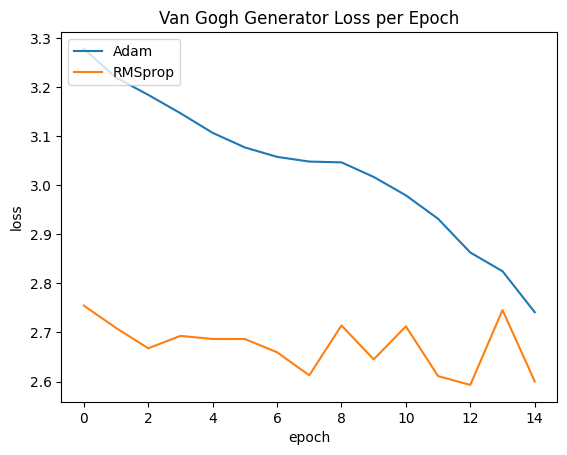

In [ ]:
hist2_van_gen_loss = [3.2777,3.2193,3.1841,3.1467,3.1067,3.077,3.0578,3.0482,3.0466,3.0169,2.9794,2.9316,2.8629,2.8248,2.7413]
hist4_van_gen_loss = [2.7548,2.7093,2.6678,2.6931,2.6868,2.6867,2.6597,2.6128,2.7144,2.6452,2.7126,2.6111,2.5932,2.7457,2.6005]
plt.plot(hist2_van_gen_loss)
plt.plot(hist4_van_gen_loss)
plt.title('Van Gogh Generator Loss per Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Adam', 'RMSprop'], loc='upper left')
plt.show();

Clearly, the graph shows us that RMSProp outperformed Adam in the Van Gogh generator. Adam eventually reached an equivalnet loss, but it took 15 epochs to match what RMSProp could do from the beginning. Generator loss, for both the Van Gogh generator and the photo generator, is clearly lower with the RMSProp optimizer. However, the discriminators seem to perform slightly better when using Adam. What would happen if we were to create a model which is a blend of the two, using RMSProp for the generators and Adam for the discriminators. This is mathematically feasible as the two deep networks are seperate identities, working indepentently of each other, connected via communication alone.

In [ ]:
cycle_gan_model_blend = CycleGan(Vangogh_gen, photo_gen, Vangogh_disc, photo_disc)

cycle_gan_model_blend.compile(
    m_gen_optimizer = Vangogh_gen_opt_rms,
    p_gen_optimizer = photo_gen_opt_rms,
    m_disc_optimizer = Vangogh_disc_opt,
    p_disc_optimizer = photo_disc_opt,
    gen_loss_fn = generator_loss,
    disc_loss_fn = discriminator_loss,
    cycle_loss_fn = calc_cycle_loss,
    identity_loss_fn = identity_loss
)

Given the graph above, we are going to stick to running the blended model for 5 epochs since RMSProp did not improve after that.

In [ ]:
hist5 = cycle_gan_model_blend.fit(tf.data.Dataset.zip((Vangogh_set, photo_set)),epochs=5)

Epoch 1/5
342/342 [==============================] - 179s 451ms/step - vangogh_gen_loss: 2.5631 - photo_gen_loss: 2.7057 - vangogh_disc_loss: 0.6453 - photo_disc_loss: 0.6025
Epoch 2/5
342/342 [==============================] - 154s 451ms/step - vangogh_gen_loss: 2.5889 - photo_gen_loss: 2.7523 - vangogh_disc_loss: 0.6530 - photo_disc_loss: 0.6077
Epoch 3/5
342/342 [==============================] - 154s 450ms/step - vangogh_gen_loss: 2.5421 - photo_gen_loss: 2.6817 - vangogh_disc_loss: 0.6636 - photo_disc_loss: 0.6298
Epoch 4/5
342/342 [==============================] - 154s 451ms/step - vangogh_gen_loss: 2.6014 - photo_gen_loss: 2.7554 - vangogh_disc_loss: 0.6580 - photo_disc_loss: 0.6146
Epoch 5/5
342/342 [==============================] - 154s 451ms/step - vangogh_gen_loss: 2.5092 - photo_gen_loss: 2.6561 - vangogh_disc_loss: 0.6736 - photo_disc_loss: 0.6350


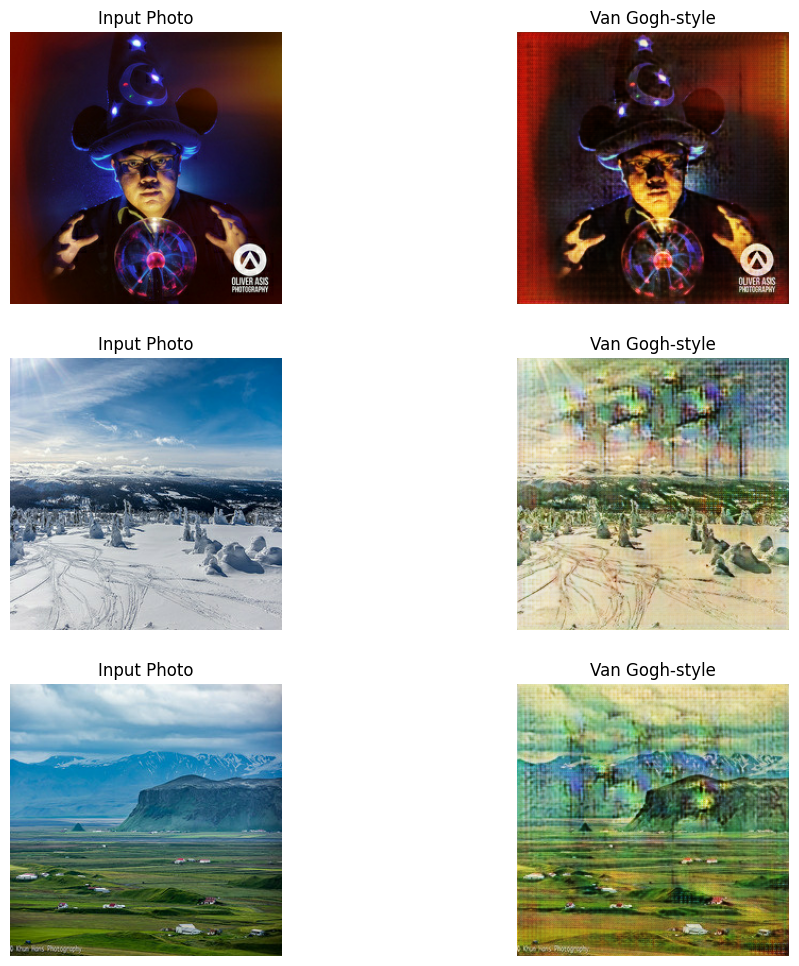

In [ ]:
_, ax = plt.subplots(3, 2, figsize=(12, 12))
for i, img in enumerate(photo_set.take(3)):
    prediction = Vangogh_gen(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Van Gogh-style")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In as little as 5 epochs, the blended model with the generators using RMSProp and the discriminators using Adam makes a obvious visual impact on the product while reducing generator loss to 2.5, lower than either previous model run for 15 epochs. Considering both optimizers and number of epochs needed, the best model is clearly the blended model.

## 5 Conclusion

This final project continued the work done during the Week 5 project. During that project, I chose to use RMSProp despite the bulk of literature which chose Adam as an optimizer. In this final project, I switched to the more popular optimizer only to discover that, at least in the case of Van Gogh, RMSProp is the more effective optimizing technique for a generator.

There was only a minimal difference in loss between the two optimizer choices when applied to the discriminator. The blended model resulted in a slightly higher loss value for the discriminator; the trade-off was an improvement to the generator. If the end goal is to create Van Gogh style pictures from photographs, the blended model with the generator using RMSProp and the discriminator using Adam yielded the best results.

Future work might look at whether or not the blended model works best with other famous artists.

## 6 Works Cited

$^{1}$ "I'm Something of a Painter Myself. Use GANs to create art - will you be the next Monet" Kaggle. https://www.kaggle.com/competitions/gan-getting-started/overview

$^{2}$ Byte, Jack. "Van Gogh TFRecord." Kaggle. https://www.kaggle.com/datasets/jackbyte/van-gogh-tfrecord

$^{3}$ Keras. https://keras.io

$^{4}$ Holbrook, Ryan. "TFRecords Basics." Kaggle. https://www.kaggle.com/code/ryanholbrook/tfrecords-basics

$^{5}$ Hui, Johnathan. "GAN - CycleGan(Playing magic with pictures)." Medium. 14 Jun, 2018, https://jonathan-hui.medium.com/gan-cyclegan-6a50e7600d7

$^{6}$ Youssef, Abdou. "Image Downsampling and Upsampling Methods," Dept of EECS, George Washington University, Washington DC.

$^{7}$ Jang, Amy. "Monet CycleGAN Tutorial." Kaggle. https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook

$^{8}$ Hui, Johnathan. "GAN - What is Generative Adversarial Networks GAN?" Medium. 19 Jun, 2018, https://jonathan-hui.medium.com/gan-whats-generative-adversarial-networks-and-its-application-f39ed278ef09

$^{9}$ Brownlee, Jason. "A Gentle Introduction to CycleGAN for Image Translation." Machine Learning Mastery. 17 Aug, 2019, https://machinelearningmastery.com/what-is-cyclegan/

$^{10}$ Zhu, Jun-Yan. "CycleGAN." Github. https://github.com/junyanz/CycleGAN

$^{11}$ Melrose, Heather. "Using GANs to Turn Photos into Monet Style Pictures." GitHub. 3 Oct, 2023, https://github.com/minesalum/msds-5511-GAN.git

$^{12}$ Brownlee, Jason "Gentle Introduction to the Adam Optimization Algorithm for Deep Learning." Machine Learning Mastery. 13 Jan, 2021, https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/


## 7 Link for GitHub Repository

https://github.com/minesalum/msds-5511-final.git